# import useful libraries

In [105]:
import numpy as np
import pandas as pd

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Input, Activation, Conv1D
from keras.layers import Dropout, MaxPooling1D, Flatten, Reshape
from keras.models import Sequential, Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import np_utils

import re

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

In [106]:
df_train = pd.read_json('train.json')
df_test = pd.read_json('test.json')

# EDA

In [107]:
df_train.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [108]:
df_test.head()

,id,ingredients
0,18009,"[baking powder, eggs, all-purpose flour, raisi..."
1,28583,"[sugar, egg yolks, corn starch, cream of tarta..."
2,41580,"[sausage links, fennel bulb, fronds, olive oil..."
3,29752,"[meat cuts, file powder, smoked sausage, okra,..."
4,35687,"[ground black pepper, salt, sausage casings, l..."


In [109]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [112]:
print(df_train['cuisine'].unique())
print("\n")
print(df_train['cuisine'].nunique())


['greek' 'southern_us' 'filipino' 'indian' 'jamaican' 'spanish' 'italian'
 'mexican' 'chinese' 'british' 'thai' 'vietnamese' 'cajun_creole'
 'brazilian' 'french' 'japanese' 'irish' 'korean' 'moroccan' 'russian']


20


In [113]:
df_train['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

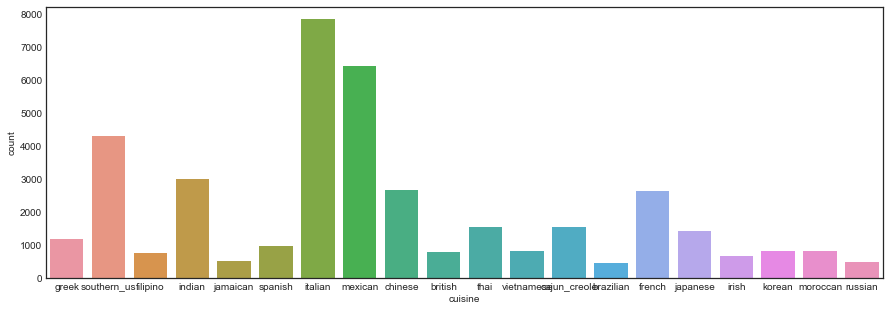

In [114]:
plt.figure(figsize=(15,5))
sns.countplot(x = "cuisine", data = df_train)

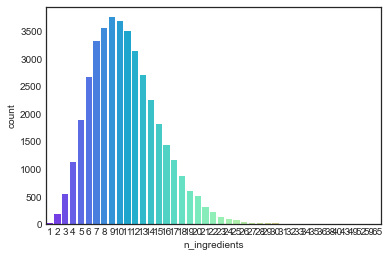

In [115]:
df_train['n_ingredients'] = df_train['ingredients'].apply(len)
sns.countplot(x='n_ingredients',data=df_train,palette='rainbow')

In [116]:
df_train[(df_train['n_ingredients'] == 1)]

,cuisine,id,ingredients,n_ingredients
940,japanese,4734,[sushi rice],1
2088,vietnamese,7833,[dried rice noodles],1
6787,indian,36818,[plain low-fat yogurt],1
7011,indian,19772,[unsalted butter],1
8181,japanese,16116,[udon],1
8852,thai,29738,[sticky rice],1
8990,indian,41124,[butter],1
10506,mexican,32631,[corn tortillas],1
13178,thai,29570,[grained],1
17804,southern_us,29849,[lemonade concentrate],1


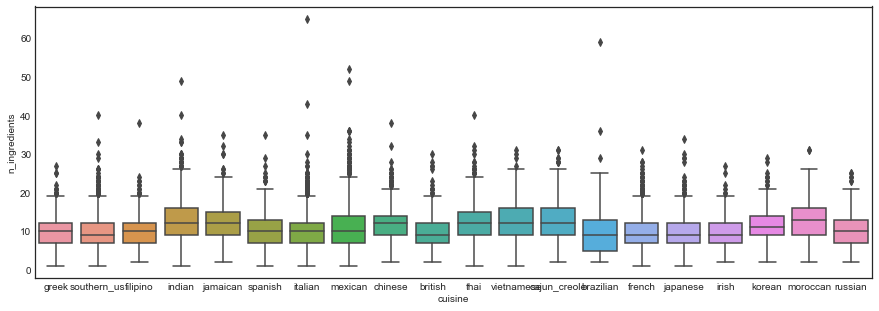

In [117]:
plt.figure(figsize=(15,5))
sns.boxplot(x = "cuisine", y = "n_ingredients", data = df_train)

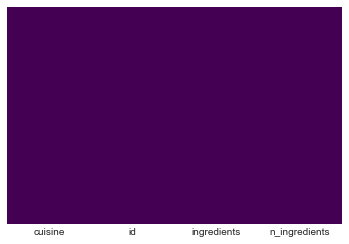

In [118]:
#check missing values if any
sns.heatmap(df_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

# Text preprocessing

In [119]:
df_train['ingredients'] = df_train['ingredients'].apply(lambda x: (" ".join(x)).lower())
df_test['ingredients'] = df_test['ingredients'].apply(lambda x: (" ".join(x)).lower())

In [120]:
#removing special characters
df_train['ingredients'] = df_train['ingredients'].apply(lambda x: re.sub(r'[^\w\d ,]','', x))
df_test['ingredients'] = df_test['ingredients'].apply(lambda x: re.sub(r'[^\w\d ,]','', x))

In [121]:
#grouping different inflected forms of a word using lemmatization
lemmatizer = WordNetLemmatizer()
df_train['ingredients'] = df_train['ingredients'].apply(lemmatizer.lemmatize)
df_test['ingredients'] = df_test['ingredients'].apply(lemmatizer.lemmatize)

In [122]:
df_train.head()

,cuisine,id,ingredients,n_ingredients
0,greek,10259,romaine lettuce black olives grape tomatoes ga...,9
1,southern_us,25693,plain flour ground pepper salt tomatoes ground...,11
2,filipino,20130,eggs pepper salt mayonaise cooking oil green c...,12
3,indian,22213,water vegetable oil wheat salt,4
4,indian,13162,black pepper shallots cornflour cayenne pepper...,20


In [123]:
#TF_IDF
tfidf = TfidfVectorizer(binary=True)

x_train = tfidf.fit_transform(df_train['ingredients']).todense()
x_test = tfidf.transform(df_test['ingredients']).todense()

In [124]:
print(x_train.shape, x_test.shape)

(39774, 3108) (9944, 3108)


In [125]:
# encoding the labels

lb = LabelEncoder()

y = lb.fit_transform(df_train['cuisine'])
y = np_utils.to_categorical(y)
print(y.shape)

(39774, 20)


In [126]:
#Train-Test Split
x_train, x_val, y_train, y_val = train_test_split(x_train, y, test_size=0.3, random_state=101)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(27841, 3108) (27841, 20) (11933, 3108) (11933, 20)


# Model Development

In [127]:
#MLP

MLP = Sequential()
MLP.add(Dense(512, input_shape=(3108, ), activation='relu'))
MLP.add(Dropout(0.5))
MLP.add(Dense(y_train.shape[1], activation='softmax'))
MLP.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

MLP.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               1591808   
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                10260     
Total params: 1,602,068
Trainable params: 1,602,068
Non-trainable params: 0
_________________________________________________________________


In [129]:
#Training MLP

file_path = "mlp"
check_point = ModelCheckpoint(file_path, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
early_stop = EarlyStopping(monitor="val_acc", mode="max", patience=3)

mlp_history = MLP.fit(x_train, 
                      y_train, 
                      batch_size=128, 
                      epochs=50, 
                      validation_data=(x_val, y_val),
                      callbacks=[check_point, early_stop])

Train on 27841 samples, validate on 11933 samples
Epoch 1/50
27841/27841 [==============================] - 19s 684us/step - loss: 0.7235 - acc: 0.7893 - val_loss: 0.7295 - val_acc: 0.7879

Epoch 00001: val_acc improved from -inf to 0.78790, saving model to mlp
Epoch 2/50
27841/27841 [==============================] - 20s 718us/step - loss: 0.6324 - acc: 0.8116 - val_loss: 0.7006 - val_acc: 0.7917

Epoch 00002: val_acc improved from 0.78790 to 0.79167, saving model to mlp
Epoch 3/50
27841/27841 [==============================] - 19s 680us/step - loss: 0.5748 - acc: 0.8251 - val_loss: 0.6894 - val_acc: 0.7918

Epoch 00003: val_acc improved from 0.79167 to 0.79175, saving model to mlp
Epoch 4/50
27841/27841 [==============================] - 20s 709us/step - loss: 0.5306 - acc: 0.8393 - val_loss: 0.6853 - val_acc: 0.7928

Epoch 00004: val_acc improved from 0.79175 to 0.79276, saving model to mlp
Epoch 5/50
27841/27841 [==============================] - 20s 708us/step - loss: 0.4969 - acc

In [130]:
mlp_best = load_model('mlp')

In [131]:
#CNN 1D

inp = Input(shape=(3108,), dtype='float32')
reshape = Reshape(target_shape=(7,444))(inp)

stacks = []
for kernel_size in [2, 3, 4]:
    conv = Conv1D(128, kernel_size, padding='same', activation='relu', strides=1)(reshape)
    pool = MaxPooling1D(pool_size=3)(conv)
    drop = Dropout(0.5)(pool)
    stacks.append(drop)

merged = Concatenate()(stacks)
flatten = Flatten()(merged)
drop = Dropout(0.5)(flatten)
outp = Dense(y_train.shape[1], activation='softmax')(drop)

TextCNN = Model(inputs=inp, outputs=outp)
TextCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

TextCNN.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 3108)         0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 7, 444)       0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 7, 128)       113792      reshape_2[0][0]                  
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 7, 128)       170624      reshape_2[0][0]                  
__________________________________________________________________________________________________
conv1d_6 (

In [132]:
#Trainin CNN 1D

file_path = "textcnn"
check_point = ModelCheckpoint(file_path, monitor="val_acc", verbose=1, save_best_only=True, mode="max")
early_stop = EarlyStopping(monitor="val_acc", mode="max", patience=3)

textcnn_history = TextCNN.fit(x_train, 
                              y_train, 
                              batch_size=128, 
                              epochs=50, 
                              validation_data=(x_val, y_val),
                              callbacks=[check_point, early_stop])

Train on 27841 samples, validate on 11933 samples
Epoch 1/50
27841/27841 [==============================] - 26s 922us/step - loss: 2.1242 - acc: 0.4180 - val_loss: 1.5325 - val_acc: 0.5865

Epoch 00001: val_acc improved from -inf to 0.58652, saving model to textcnn
Epoch 2/50
27841/27841 [==============================] - 27s 970us/step - loss: 1.3209 - acc: 0.6294 - val_loss: 1.1336 - val_acc: 0.6762

Epoch 00002: val_acc improved from 0.58652 to 0.67619, saving model to textcnn
Epoch 3/50
27841/27841 [==============================] - 27s 965us/step - loss: 1.0730 - acc: 0.6920 - val_loss: 0.9833 - val_acc: 0.7119

Epoch 00003: val_acc improved from 0.67619 to 0.71189, saving model to textcnn
Epoch 4/50
27841/27841 [==============================] - 27s 983us/step - loss: 0.9484 - acc: 0.7259 - val_loss: 0.9009 - val_acc: 0.7369

Epoch 00004: val_acc improved from 0.71189 to 0.73695, saving model to textcnn
Epoch 5/50
27841/27841 [==============================] - 27s 979us/step - lo

In [133]:
textcnn_best = load_model('textcnn')

In [134]:
#Prediction

mlp_pred = mlp_best.predict(x_test)
textcnn_pred = textcnn_best.predict(x_test)

ensemble_pred = (mlp_pred + textcnn_pred).argmax(axis=1)
final = lb.inverse_transform(ensemble_pred)

C:\Users\SUVID ANAND\ANACONDA\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [136]:
#csv file

sub = pd.DataFrame({'id': df_test.id, 'cuisine': final})
sub.to_csv('submission.csv', index = False)